In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO, AlignIO, Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
from biopandas.pdb import PandasPdb

In [2]:
# read in candidate alpha-carboxysome operon genes
df = pd.read_csv('extracted_genes.csv')

In [3]:
df.head(3)

,Unnamed: 0,aa_seq,gene_id,nt_seq,pfam_ids,pfam_names,record_accession,record_description,unique_record_id
0,0,MDQSNRYADLTLSEEKLIADGNHLLVAYRLKPAAGYGFLEVAAHVA...,2678247951,ATGGATCAGTCGAATCGTTACGCTGACTTAACTCTATCAGAAGAGA...,"pfam02788, pfam00016","RuBisCO_large_N, RuBisCO_large",2675903511,Ga0127234_101 Thiomicrospira sp. XS5 : Ga01272...,2675903511_Ga0127234_101
1,1,MAKTYNAGVKEYRETYWMPDYEPKDSDFLACFKVIPQDGVPREEVA...,2678247954,ATGGCTAAGACTTATAACGCCGGTGTAAAAGAATACCGCGAAACGT...,"pfam02788, pfam00016","RuBisCO_large_N, RuBisCO_large",2675903511,Ga0127234_101 Thiomicrospira sp. XS5 : Ga01272...,2675903511_Ga0127234_101
2,2,MSTVQDYPSRLSDPASRKAETFSYLPKMSDDQIRSQVEYIISKGWN...,2678247955,ATGAGTACAGTACAAGATTATCCTTCACGTCTTTCTGATCCGGCAT...,pfam00101,RuBisCO_small,2675903511,Ga0127234_101 Thiomicrospira sp. XS5 : Ga01272...,2675903511_Ga0127234_101


In [5]:
# find rubisco small and large subunits within 12 ORFs of csos2
cbbl0 = []
cbbs0 = []
# iterate over all unique records accessions in gene list
for ra in df.record_accession.unique():
    # get dataframe for all entries matching a particular accession
    ra_entries = df.loc[df.record_accession == ra]
    
    # check if CsoS2 pfam is among the genes
    if 'pfam12288' in [i for i in ra_entries.pfam_ids]:
        # get the gene ids for all csos2s in record accession
        s2geneids = ra_entries.loc[ra_entries.pfam_ids=='pfam12288'].gene_id

        # iterate over s2ids
        for s2id in s2geneids:
            # grab entries within 12 of csos2
            nears2 = ra_entries.loc[(ra_entries.gene_id >= s2id - 12) & (ra_entries.gene_id <= s2id + 12)]
            
            # append entries containing pfam for large and small rubisco subunits
            cbbl0.append(nears2.index[['pfam00016' in i for i in nears2.pfam_ids]].to_list())
            cbbs0.append(nears2.index[['pfam00101' in i for i in nears2.pfam_ids]].to_list())

# flatten nested lists
cbbl = [i for j in cbbl0 for i in j]
cbbs = [i for j in cbbs0 for i in j]

In [8]:
# write amino acid sequences to fasta files using the df indices.
def write_fasta(indexlist, subunittype, fastaname):
    seqs = []
        
    for i,j in zip(zip(df.iloc[indexlist].unique_record_id,df.iloc[indexlist].gene_id), df.iloc[indexlist].aa_seq):
        if '*' in j:
            seq_aa = Seq.Seq(j[:j.find('*')])
        else:
            seq_aa = Seq.Seq(j)
        seqs.append(SeqRecord(seq_aa, i[0], description="%s_%i" % (subunittype, i[1])))
    with open(fastaname, "w") as f: 
        SeqIO.write(seqs, f, "fasta")
    
    return None

In [9]:
write_fasta(cbbl, "CbbL", "2022_05_19_cbbL.fa")
write_fasta(cbbs, "CbbS", "2022_05_19_cbbS.fa")

In [10]:
# cluster at <95% identity in the large subunit (the more conserved) to unbias the dataset
! usearch -cluster_fast "2022_05_19_cbbL.fa" -id 0.95 -uc "2022_05_19_cbbL_uc95.uc"

usearch v11.0.667_i86linux32, 4.0Gb RAM (8.0Gb total), 12 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only

00:00 41Mb    100.0% Reading 2022_05_19_cbbL.fa
00:00 7.2Mb  CPU has 12 cores, defaulting to 10 threads
00:00 92Mb    100.0% DF
00:00 92Mb   254 seqs, 118 uniques, 83 singletons (70.3%)
00:00 92Mb   Min size 1, median 1, max 28, avg 2.15
00:00 95Mb    100.0% DB
00:00 146Mb   100.0% 48 clusters, max size 70, avg 5.3
                                                      
      Seqs  118
  Clusters  48
  Max size  70
  Avg size  5.3
  Min size  1
Singletons  20, 16.9% of seqs, 41.7% of clusters
   Max mem  146Mb
      Time  1.00s
Throughput  118.0 seqs/sec.



In [11]:
# helper function to parse uclust files and write as fasta
# written by Yinon Bar-On from Ron Milo's lab at the Weizmann Institute
def parse_uclust(infile,fasta,outfasta,outfile):
    header = ['Type','Cluster','Size','%Id','Strand','Qlo','Tlo','Alignment','Query','Target']
    uclust = pd.read_csv(infile, sep='\t', names=header, index_col=False)
    uclust.loc[uclust['Target'] == '*','Target'] = uclust.loc[uclust['Target'] == '*','Query']
    uclust = uclust[uclust['Type'] !='S']
    centroids = uclust[uclust['Type']=='C']
    c_list = centroids.Target.values
    c_list = [c.split(" ")[0] for c in c_list]

    sequences = []
    for record in SeqIO.parse(fasta, "fasta"):
        if record.id in c_list:
            sequences.append(record)

    seq2 = []
    seq3 = []
    for i,record in enumerate(sequences):
        if not record.id in seq2:
            seq2.append(record.id)
            seq3.append(record)
    with open(outfasta, "w") as output_handle:
        SeqIO.write(seq3, output_handle, "fasta")

In [12]:
#Use Yinon's ucluster parsing function to write out new fasta
parse_uclust(infile="2022_05_19_cbbL_uc95.uc",
             fasta="2022_05_19_cbbL.fa",
             outfasta="2022_05_19_cbbL_uc95.fa",
             outfile="2022_05_19_cbbL_uc95.csv"
            )

In [14]:
# read in clustered large subunits and all small subunits written above
clust_cbbls = list(SeqIO.parse("2022_05_19_cbbL_uc95.fa", "fasta"))
cbbss = list(SeqIO.parse("2022_05_19_cbbS.fa", "fasta"))

In [15]:
# pair up the small and large subunits from the same locus if they are adjacent
cbbl_paired = []
cbbs_paired = []
lgeneids = []
for cl in clust_cbbls:
    lgeneid = cl.description[cl.description.rfind('_')+1:]

    for cs in cbbss:
        if cl.id in cs.id:
            sgeneid = cs.description[cs.description.rfind('_')+1:]
            if np.abs(int(sgeneid) - int(lgeneid)) == 1:
                if lgeneid not in lgeneids:
                    cbbl_paired.append(cl)
                    lgeneids.append(lgeneid)
                    cbbs_paired.append(cs)

In [16]:
# enter the H. neapolitanus sequences and prepend them to the set of paired CbbLS
HnCbbS = SeqRecord(Seq.Seq("MAEMQDYKQSLKYETFSYLPPMNAERIRAQIKYAIAQGWSPGIEHVEVKNSMNQYWYMWKLPFFGEQNVDNVLAEIEACRSAYPTHQVKLVAYDNYAQSLGLAFVVYRGN"),
                  id="HnCbbS", name="HnCbbS", description="rubisco small subunit")
HnCbbL = SeqRecord(Seq.Seq("MAVKKYSAGVKEYRQTYWMPEYTPLDSDILACFKITPQPGVDREEAAAAVAAESSTGTWTTVWTDLLTDMDYYKGRAYRIEDVPGDDAAFYAFIAYPIDLFEEGSVVNVFTSLVGNVFGFKAVRGLRLEDVRFPLAYVKTCGGPPHGIQVERDKMNKYGRPLLGCTIKPKLGLSAKNYGRAVYECLRGGLDFTKDDENINSQPFMRWRDRFLFVQDATETAEAQTGERKGHYLNVTAPTPEEMYKRAEFAKEIGAPIIMHDYITGGFTANTGLAKWCQDNGVLLHIHRAMHAVIDRNPNHGIHFRVLTKILRLSGGDHLHTGTVVGKLEGDRASTLGWIDLLRESFIPEDRSRGIFFDQDWGSMPGVFAVASGGIHVWHMPALVNIFGDDSVLQFGGGTLGHPWGNAAGAAANRVALEACVEARNQGRDIEKEGKEILTAAAQHSPELKIAMETWKEIKFEFDTVDKLDTQNR"),
                  id="HnCbbL", name="HnCbbL", description="rubisco large subunit")

cbbs_paired.insert(0, HnCbbS)
cbbl_paired.insert(0, HnCbbL)

In [17]:
# write paired fasta files
with open("2022_05_20_CbbS_paired.fa", "w") as f: 
    SeqIO.write(cbbs_paired, f, "fasta")

with open("2022_05_20_CbbL_paired.fa", "w") as f: 
    SeqIO.write(cbbl_paired, f, "fasta")

In [18]:
# use mafft to generate sequence alignment
! mafft --auto --quiet "2022_05_20_CbbL_paired.fa"  > "2022_05_20_CbbL_paired_aligned.fa"
! mafft --auto --quiet "2022_05_20_CbbS_paired.fa"  > "2022_05_20_CbbS_paired_aligned.fa"

In [19]:
# generate weblogo datasets to characterize diversity at each alignment position
! weblogo -f "2022_05_20_CbbL_paired_aligned.fa" -o "cbbl_weblogo.dat" -F logodata
! weblogo -f "2022_05_20_CbbS_paired_aligned.fa" -o "cbbs_weblogo.dat" -F logodata

In [20]:
# read weblogo datafiles into pandas dataframes
wll = pd.read_csv("cbbl_weblogo.dat", header=7, delimiter="\t", index_col=0, skipfooter=1, engine="python")
wls = pd.read_csv("cbbs_weblogo.dat", header=7, delimiter="\t", index_col=0, skipfooter=1, engine="python")

In [21]:
# calculates the positional entropy (with no residue bias priors)
# ignores zeros.
def entropy(matrix0):
    matrix = np.where(matrix0 != 0, matrix0, np.nan)/matrix0.max()
    ent = -np.nansum(matrix*np.log2(matrix), axis=1)
    return ent

In [23]:
# calculate the entropy using the occurrences of all amino acids
entsmall = entropy(wls.iloc[:,0:20].to_numpy())
entlarge = entropy(wll.iloc[:,0:20].to_numpy())

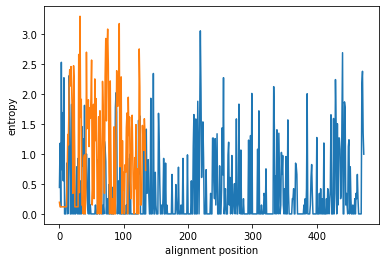

In [24]:
plt.plot(entlarge)
plt.plot(entsmall)
plt.xlabel("alignment position")
plt.ylabel("entropy")
plt.show()

In [25]:
# use biopandas to import the Hn rubisco
ruSVD = PandasPdb().fetch_pdb('1svd')

In [26]:
# get the Hn alignment from the fastas
def get_Hn_align(alignfile):
    alignments = AlignIO.read(alignfile, "fasta")
    for alignment in alignments:
        if "HnCbb" in alignment.id:
            return alignment
    print("Didn't find the expected Halo sequences.")
    return None

In [27]:
# convert the alignment index to the sequence index (ie. ignore the gaps)
def align_indices(align_seq):
    align_inds = []
    for ind, aa in enumerate(align_seq):
        if aa != '-':
            align_inds.append(ind + 1)
    return align_inds

In [28]:
# get the entropy at the aa positions in HnCbbL and HnCbbS
cbbl_inds = align_indices(get_Hn_align("2022_05_20_CbbL_paired_aligned.fa").seq)
cbbs_inds = align_indices(get_Hn_align("2022_05_20_CbbS_paired_aligned.fa").seq)

cbbl_ent = entropy(wll.loc[cbbl_inds].iloc[:,0:20].to_numpy())
cbbs_ent = entropy(wls.loc[cbbs_inds].iloc[:,0:20].to_numpy())

In [29]:
# takes a chain identifier, the entropy calculated above and a biopandas pdb object and hijacks the b-factor with entropy
def rewrite_bfactors(chain_id, ru_ent, pdbstruct):
    pdbinds0 = pdbstruct.df['ATOM'].loc[pdbstruct.df['ATOM']['chain_id'] == chain_id]['residue_number'].unique()
    
    pdbinds = [pdbi for pdbi in pdbinds0 if pdbi <= len(ru_ent)]
    
    for pdbind in pdbinds:
        pdbstruct.df['ATOM'].loc[(pdbstruct.df['ATOM']['chain_id'] == chain_id)
                                   & (pdbstruct.df['ATOM']['residue_number'] == pdbind),'b_factor'] = ru_ent[pdbind - 1]
    return None

In [30]:
# rewrite the b-factors for the large (chain A) and small (chain M) subunits in PDB 1SVD
rewrite_bfactors('A', cbbl_ent, ruSVD)
rewrite_bfactors('M', cbbs_ent, ruSVD)

In [31]:
# write new pdb to file
ruSVD.to_pdb(path='entropy_rubisco.pdb', 
            records=None, 
            gz=False, 
            append_newline=True)

In [32]:
# same as re_write_bfactors but can take a full holoenzyme model
def write_full_bfactors(pdbstruct, small_ent, large_ent):

    for cid in pdbstruct.df['ATOM']['chain_id'].unique():
        resnum = pdbstruct.df['ATOM'].loc[pdbstruct.df['ATOM']['chain_id']==cid]['residue_number'].max()
        if (resnum > 100) & (resnum <= 115):
            rewrite_bfactors(cid, small_ent, pdbstruct)
        elif (resnum > 480) & (resnum <= 505):
            rewrite_bfactors(cid, large_ent, pdbstruct)
        else:
            print("Unknown chain %s" % cid)
            
    return None     

In [33]:
# Load atomic models for two rubiscos at a fibril interface and write entropy to b-factors for both
# use biopandas to import the Hn rubisco
rumod1 = PandasPdb().read_pdb('pdbModel.pdb')
# use biopandas to import the Hn rubisco
rumod2 = PandasPdb().read_pdb('pdbModel2.pdb')
write_full_bfactors(rumod1, cbbs_ent, cbbl_ent)
write_full_bfactors(rumod2, cbbs_ent, cbbl_ent)

In [34]:
# write modified PDBs with entropy 'b-factors'
rumod1.to_pdb(path='rumod1.pdb', 
            records=None, 
            gz=False, 
            append_newline=True)

rumod2.to_pdb(path='rumod2.pdb', 
            records=None, 
            gz=False, 
            append_newline=True)

In [277]:
# generate weblogo images for helices near rubisco interaction interface
# ! weblogo -f "2022_05_20_CbbS_paired_aligned.fa" -o "cbbs_21_27.eps" -l 43 -u 50 -F eps -c chemistry
# ! weblogo -f "2022_05_20_CbbS_paired_aligned.fa" -o "cbbs_70_82.eps" -l 92 -u 104 -F eps -c chemistry
# ! weblogo -f "2022_05_20_CbbL_paired_aligned.fa" -o "cbbl_434_444.eps" -l 434 -u 444 -F eps -c chemistry
# ! weblogo -f "2022_05_20_CbbL_paired_aligned.fa" -o "cbbl_446_456.eps" -l 446 -u 456 -F eps -c chemistry